## <b>AdaIN Style Transfer Tutorial</b>

* 원본 논문: [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization (ICCV 2017)](https://arxiv.org/abs/1703.06868)
* <b>Feed-Forward Network</b>를 이용하여 <b>임의의(arbitrary)</b> 스타일 이미지를 활용한 <b>스타일 전송(style transfer)</b>을 실시간으로 수행합니다.
    * 이미지에 대한 기울기(gradient)를 직접 구하지 않아도 되므로 <b>훨씬 빠르게</b> 스타일을 전송할 수 있습니다.
* 소스코드를 실행하기 전에 **[런타임]** - **[런타임 유형 변경]** - **[GPU]**로 설정되어 있는지 확인합니다.
* 본 코드는 논문에서 제시한 파라미터 및 설정을 온전히 따르고 있습니다.

#### <b>AdaIN Style Transfer 네트워크</b>

* 앞서 정의한 인코더와 디코더를 이용하는 하나의 네트워크를 정의합니다.
* 먼저 인코더(encoder)를 통해 feature map을 추출한 뒤에 AdaIN을 거쳐 Style Transfer를 수행합니다.
* 디코더는 처리된 feature를 입력받아 결과 이미지를 생성합니다.
* <b>본 실습에서 사용하지는 않지만</b> 아키텍처를 이해하기 위해 코드를 확인해 봅시다.

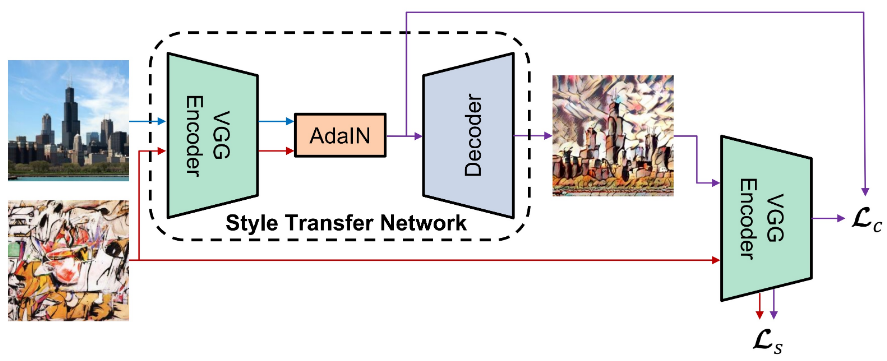

#### <b>실습에 필요한 라이브러리 불러오기 및 환경 설정</b>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [67]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.utils import save_image

from PIL import Image
from IPython.display import Image as display_image

# for file path
import natsort
import platform
import glob
import os

import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow # cv2_imshow(img)
import torchvision.transforms as transforms

#### <b>인코더 및 디코더 네트워크</b>

* <b>인코더(Encoder)</b>: VGG 형식의 네트워크를 사용하여 이미지로부터 특징(feature)을 추출(extract)합니다.
* <b>디코더(Decoder)</b>: 인코더와 유사한 네트워크이지만 <b>반대로 해상도(너비 X 높이)를 키우는 방식으로 동작</b>합니다.

#### <b>인코더(Encoder)</b>

* VGG 네트워크에서 맥스 풀링(max pooling)을 총 4번 진행하지만, Style Transfer에서는 ReLU4_1까지만 사용합니다.
    * 따라서 사실상 다운샘플링(downsampling)은 3번까지만 진행된다고 이해할 수 있습니다.

In [3]:
# 인코더(Encoder) 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

#### <b>디코더(Decoder)</b>

* 디코더는 인코더 네트워크를 반대로 뒤집은 것과 유사한 구조를 가집니다.
* 인코더 파트에서 3번의 다운샘플링(downsampling)을 거치므로, 디코더에서는 3번의 업샘플링(upsampling)을 거칩니다.

In [4]:
# 디코더(Decoder) 정의
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

#### <b>사전 학습된(Pre-trained) 모델 불러오기</b> 

In [5]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth

--2021-08-20 15:24:25--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 40.108.156.33
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|40.108.156.33|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FYnM2WEVTMzdvdExnV1c1Y2F2Q1k5WUJ5R09uWEpENXdDMFdaZ1FQcDh2QUpnP3J0aW1lPTNwUWRtZTVqMlVn [following]
--2021-08-20 15:24:27--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19

In [6]:
# get trained model
decoder.eval() # https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31]) # ReLU4_1까지만 사용

In [7]:
def calc_mean_std(feat, eps=1e-5):
    ''' 이미지의 각 채널 평균(mean)과 표준편차(std) 값을 계산 '''
    size = feat.size()
    assert (len(size) == 4) # Feature Map의 형태: (N: 배치 크기, C: 채널 크기, H: 높이, W: 너비)
    N, C = size[:2]  # 한 번에 하나의 이미지만 넣을 것이므로 N은 1
    feat_var = feat.view(N, C, -1).var(dim=2) + eps # 입실론(epsilon)은 0으로 나누는 것을 예방하기 위한 작은 상수
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

In [8]:
def adaptive_instance_normalization(content_feat, style_feat):
    ''' content image에 style 적용'''
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    # 평균(mean)과 표준편차(std)를 이용하여 정규화 수행
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    # 정규화 이후에 style feature의 statistics를 가지도록 설정
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

In [9]:
def style_transfer(vgg, decoder, content, style, alpha=1.0): # main
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

In [10]:
def test_transform(size=512): # main
    ''' 이미지 전처리 '''
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform
content_tf = test_transform()
style_tf = test_transform()

전체 소요 시간: 0.7


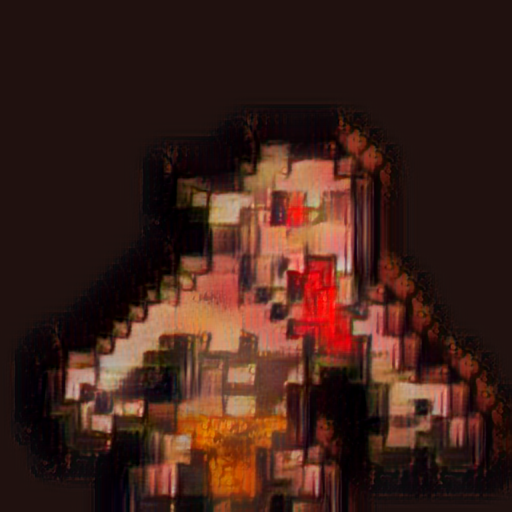

In [152]:
import time
start = time.time()

# 디렉터리 내 이미지 전체에 스타일 변이 코드 추가 필요

# main
content_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/goblin_64x64/sprite_00.png"
style_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/horror/horror18.jpg"

content_image = Image.open(str(content_location)).convert("RGB") # 배경 요소 제거
content = content_tf(content_image)
style = style_tf(Image.open(str(style_location)))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)

with torch.no_grad():
    img_transformed = style_transfer(vgg, decoder, content, style, alpha=0.6) # alpha 파라미터를 조절하여 콘텐츠 비율을 증가시킬 수 있습니다.
img_transformed = img_transformed.cpu()

# alpha channel 추가 코드  추가 필요
final = img_transformed.numpy()


save_image(img_transformed, '/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/test.png')

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

# 결과 이미지 출력
display_image('/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/test.png')

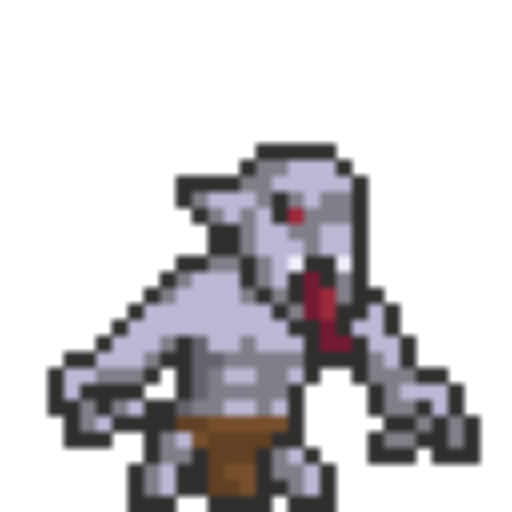

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


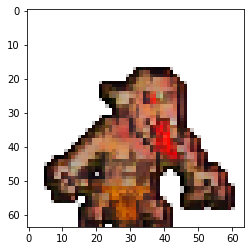

In [153]:
origin_image = cv.imread(content_location, cv.IMREAD_UNCHANGED)
origin_image_shape = origin_image.shape

# torch의 shape 순서를 바꿔줌
img = img_transformed[0].permute(1, 2, 0)

# model이 반환한 이미지와 사이즈 동일하게 origin image 변환(자동화 완료)
shape = img.shape
x, y = shape[0], shape[1]
origin_image_resized = cv.resize(origin_image, dsize=(y,x))
cv2_imshow(origin_image_resized)

# alpha channel 추가
final = cv.cvtColor(np.float32(img), cv.COLOR_RGB2RGBA)
final[:, :, 3] = origin_image_resized[:,:,3]

# final image 사이즈를 original image 사이즈로 변환
x, y = origin_image_shape[0], origin_image_shape[1]
final = cv.resize(final, dsize=(y,x))

plt.imshow(final)

In [ ]:
## main code
import time
start = time.time()

# 스타일 폴더 리스트
for SF_index, SF_value in enumerate(style_folder_list):
  style_images_list = glob.glob(style_folder_list[SF_index] + "/*")
  style_folder_name = os.path.split(style_folder_list[SF_index]) # horror, ice, dark .etc

  style_images_list = natsort.natsorted(style_images_list)

  # 스타일 이미지 리스트
  for SI_index, SI_value in enumerate(style_images_list):
    style_image_name = os.path.split(style_images_list[SI_index]) # horror1, horror2, horror3, .etc
    
    # 스타일 이미지 선택
    style = style_tf(Image.open(str(style_path)))
    style = style.to(device).unsqueeze(0)

    # 콘텐트 폴더 리스트
    for CF_index, CF_value in enumerate(content_folder_list):

      #콘텐트 이미지 리스트
      content_images_list = glob.glob(content_folder_list[CF_index] + "/*")
      content_images_list = natsort.natsorted(content_images_list)

      # 스타일 전이
      for CI_index, CI_value in enumerate(content_images_list):
        location = CI_value

        # 저장 경로 생성
        asset_folder = os.path.split(content_folder_list[CF_index]) # gobline, zombie, male .etc
        asset_name = os.path.split(CI_value)

        save_folder_style = styled_location + style_folder_name[1]
        save_folder_style_index = save_folder_style + "/" + style_image_name[1]
        save_folder_style_index_content = save_folder_style_index + "/" + asset_folder[1]
        
        createFolder(save_folder_style) # horror, ice, dark
        createFolder(save_folder_style_index) # horror1, horror2, horror3
        createFolder(save_folder_style_index_content) # goblin, zombie, male

        save_path = save_folder_style_index_content + "/"
        save_path = save_path + asset_name[1] + f'_{CI_index}_final.png'

        # 이미 있는 파일이면 건너뛰기
        if os.path.exists(save_path):
          continue
        else:
          origin_image = cv.imread(location, cv.IMREAD_UNCHANGED)
          origin_image_shape = origin_image.shape

          # style transfer
          content_image = Image.open(str(content_path)).convert("RGB") # 배경 요소 제거
          content = content_tf(content_image)

          with torch.no_grad():
            output = style_transfer(vgg, decoder, content, style, alpha=1.0) # alpha 파라미터를 조절하여 콘텐츠 비율을 증가시킬 수 있습니다.
          output = output.cpu()

          # alpha channel 추가
          final = cv.cvtColor(output, cv.COLOR_RGB2RGBA)
          final[:, :, 3] = origin_image_resized[:,:,3]

          # final image 사이즈를 original image 사이즈로 변환
          x, y = origin_image_shape[0], origin_image_shape[1]
          final = cv.resize(final, dsize=(y,x))

          # 저장
          cv.imwrite(save_path, final)
          cv2_imshow(final)

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))